In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
ls

gdrive/  sample_data/


In [4]:
cd /content/gdrive/MyDrive/ACRIN_lung_cancer_dataset/

/content/gdrive/MyDrive/ACRIN_lung_cancer_dataset


In [5]:
ls

1batch1/   1batch17/  1batch24/  1batch9/
1batch10/  1batch18/  1batch25/  combined_all_SUVmetrics_11_28_25.tsv
1batch11/  1batch19/  1batch3/   combined_all.tsv
1batch12/  1batch2/   1batch4/   combined_data_for_ML.tsv
1batch13/  1batch20/  1batch5/   combined_metadata.tsv
1batch14/  1batch21/  1batch6/   lung_segmentation_2d_model.h5
1batch15/  1batch22/  1batch7/   metadata/
1batch16/  1batch23/  1batch8/


In [4]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.7 MB/s eta 0:00:00


In [5]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import json

# Step 1: Scan subdirectories containing both CT and PET folder

In [6]:
import os
import pydicom

# Step 1: Identify patient directories
print("Identifying patient directories...")
all_items = os.listdir('.')
patient_dirs = [item for item in all_items if os.path.isdir(item) and item.startswith('ACRIN-')]

print(f"Found {len(patient_dirs)} patient directories: {patient_dirs}")

# Dictionary to store paths
patient_data_paths = {}

# Step 2: Iterate through patients
print("\nLocating PET and CT subdirectories...")
for patient_dir in patient_dirs:
    print(f"\nProcessing: {patient_dir}")
    patient_path = os.path.join('.', patient_dir)

    # Get second level directories
    second_level_dirs = [item for item in os.listdir(patient_path)
                         if os.path.isdir(os.path.join(patient_path, item))]

    # Store all valid CT/PET pairs
    valid_pairs = []

    for second_level_dir in second_level_dirs:
        second_level_path = os.path.join(patient_path, second_level_dir)

        # Get third level directories
        third_level_dirs = [item for item in os.listdir(second_level_path)
                           if os.path.isdir(os.path.join(second_level_path, item))]

        ct_folder_found = None
        pet_folder_found = None

        for third_level_dir in third_level_dirs:
            third_level_path = os.path.join(second_level_path, third_level_dir)
            folder_name_lower = third_level_dir.lower()

            # Check DICOM modality
            dicom_files = [f for f in os.listdir(third_level_path) if f.endswith('.dcm')]

            if dicom_files:
                sample_dicom_path = os.path.join(third_level_path, dicom_files[0])
                try:
                    dataset = pydicom.dcmread(sample_dicom_path, stop_before_pixels=True)
                    modality = getattr(dataset, 'Modality', None)

                    if modality == 'CT':
                        ct_folder_found = third_level_path

                    elif modality == 'PT':
                        # Skip folders with 'uncorrected' in name
                        if 'uncorrected' in folder_name_lower:
                            continue
                        else:
                            pet_folder_found = third_level_path

                except Exception as e:
                    print(f"  Error reading {sample_dicom_path}: {e}")

        # If both CT and PET found, add to list
        if ct_folder_found and pet_folder_found:
            valid_pairs.append({
                'date_folder': second_level_dir,
                'ct': ct_folder_found,
                'pet': pet_folder_found
            })
            print(f"  Found pair in: {second_level_dir}")

    # Store all pairs for this patient
    if valid_pairs:
        for i, pair in enumerate(valid_pairs):
            # Create unique key for each date folder
            if len(valid_pairs) == 1:
                key = patient_dir
            else:
                key = f"{patient_dir}_{i+1}"

            patient_data_paths[key] = {
                'pet': pair['pet'],
                'ct': pair['ct'],
                'date_folder': pair['date_folder']
            }
            print(f"  ✓ Added: {key}")
    else:
        print(f"  ⚠ Skipping {patient_dir} - no valid CT/PET pair found")

# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

if patient_data_paths:
    for patient_id, paths in patient_data_paths.items():
        print(f"\n{patient_id}:")
        print(f"  Date folder: {paths['date_folder']}")
        print(f"  PET: {paths['pet']}")
        print(f"  CT:  {paths['ct']}")
else:
    print("No patient data paths identified.")

print(f"\nTotal scan pairs found: {len(patient_data_paths)}")

Identifying patient directories...
Found 10 patient directories: ['ACRIN-NSCLC-FDG-PET-251', 'ACRIN-NSCLC-FDG-PET-250', 'ACRIN-NSCLC-FDG-PET-245', 'ACRIN-NSCLC-FDG-PET-244', 'ACRIN-NSCLC-FDG-PET-242', 'ACRIN-NSCLC-FDG-PET-249', 'ACRIN-NSCLC-FDG-PET-241', 'ACRIN-NSCLC-FDG-PET-248', 'ACRIN-NSCLC-FDG-PET-243', 'ACRIN-NSCLC-FDG-PET-247']

Locating PET and CT subdirectories...

Processing: ACRIN-NSCLC-FDG-PET-251
  Found pair in: 12-31-1959-NA-PET1PETCTLUNGRTP Adult-09810
  ✓ Added: ACRIN-NSCLC-FDG-PET-251

Processing: ACRIN-NSCLC-FDG-PET-250
  Found pair in: 08-01-1960-NA-F-18 FDG PETWhole Bod-00116
  ✓ Added: ACRIN-NSCLC-FDG-PET-250

Processing: ACRIN-NSCLC-FDG-PET-245
  ⚠ Skipping ACRIN-NSCLC-FDG-PET-245 - no valid CT/PET pair found

Processing: ACRIN-NSCLC-FDG-PET-244
  Found pair in: 01-13-1960-NA-PET1PETCTWholeBody Adult-80571
  Found pair in: 06-24-1960-NA-PET1PETCTWholeBody Adult-55835
  ✓ Added: ACRIN-NSCLC-FDG-PET-244_1
  ✓ Added: ACRIN-NSCLC-FDG-PET-244_2

Processing: ACRIN-NSCLC

# Step 2: Load all dicom files from the subfolders

In [7]:
pip install simpleitk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 52.8 MB/s eta 0:00:00


## Read both CT and PET scans
- Extract metadata from the scans (Patient ID; weight; modality...)
- convert the PET values to SUV values
- Align the PET images with CT images to same shape
- Convert CT values to Haunsfield values if needed

In [8]:
import SimpleITK as sitk
import pydicom
import numpy as np
import os

def load_and_align_pet_ct(pet_folder, ct_folder, convert_units=True, verbose=True):

    def load_dicom_series_sitk(folder_path):
        """Load DICOM series using SimpleITK"""
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        return image

    def load_dicom_with_metadata(dicom_dir):
        """Load DICOM files and extract metadata"""
        dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]

        if not dicom_files:
            raise ValueError(f"No DICOM files found in {dicom_dir}")

        dicom_data = []
        for dicom_file in dicom_files:
            try:
                dataset = pydicom.dcmread(os.path.join(dicom_dir, dicom_file))
                instance_number = getattr(dataset, 'InstanceNumber', None)
                slice_location = getattr(dataset, 'SliceLocation', None)
                dicom_data.append({
                    'filename': dicom_file,
                    'dataset': dataset,
                    'instance_number': instance_number,
                    'slice_location': slice_location
                })
            except Exception as e:
                print(f"Error reading {dicom_file}: {e}")

        # Sort by InstanceNumber and SliceLocation
        dicom_data.sort(key=lambda x: (
            x['instance_number'] if x['instance_number'] is not None else float('inf'),
            x['slice_location'] if x['slice_location'] is not None else float('inf'),
            x['filename']
        ))

        if not dicom_data:
            raise ValueError(f"No valid DICOM data loaded from {dicom_dir}")

        # Extract metadata from first file
        first_ds = dicom_data[0]['dataset']

        metadata = {
            'rows': first_ds.Rows,
            'columns': first_ds.Columns,
            'pixel_spacing': getattr(first_ds, 'PixelSpacing', [1.0, 1.0]),
            'slice_thickness': getattr(first_ds, 'SliceThickness', 1.0),
            'patient_id': str(getattr(first_ds, 'PatientID', 'Unknown')),
            'modality': str(getattr(first_ds, 'Modality', 'Unknown')),
            'rescale_slope': float(getattr(first_ds, 'RescaleSlope', 1.0)),
            'rescale_intercept': float(getattr(first_ds, 'RescaleIntercept', 0.0))
        }

        # Extract SUV parameters if PET
        if metadata['modality'] == 'PT':
            suv_metadata = extract_suv_parameters(first_ds)
            metadata.update(suv_metadata)

        return dicom_data, metadata

    def extract_suv_parameters(ds):
        """Extract SUV calculation parameters from PET DICOM"""
        suv_params = {}

        try:
            suv_params['patient_weight'] = float(getattr(ds, 'PatientWeight', None))
        except (TypeError, ValueError):
            suv_params['patient_weight'] = None

        try:
            radiopharm_info = getattr(ds, 'RadiopharmaceuticalInformationSequence', [{}])[0]
            suv_params['injected_dose'] = float(getattr(radiopharm_info, 'RadionuclideTotalDose', None))
        except (TypeError, ValueError, IndexError):
            suv_params['injected_dose'] = None

        try:
            suv_params['half_life'] = float(getattr(radiopharm_info, 'RadionuclideHalfLife', None))
        except (TypeError, ValueError):
            suv_params['half_life'] = None

        try:
            suv_params['decay_correction'] = str(getattr(ds, 'DecayCorrection', 'Unknown'))
        except:
            suv_params['decay_correction'] = 'Unknown'

        return suv_params

    def convert_image_to_suv(pet_image, metadata):
        """Convert SimpleITK PET image to SUV"""
        # Convert to numpy array
        pet_array = sitk.GetArrayFromImage(pet_image)

        # Apply rescale
        pet_rescaled = pet_array * metadata['rescale_slope'] + metadata['rescale_intercept']

        # Calculate SUV if parameters available
        if metadata['patient_weight'] is not None and metadata['injected_dose'] is not None:
            patient_weight_g = metadata['patient_weight'] * 1000
            pet_suv = (pet_rescaled * patient_weight_g) / metadata['injected_dose']
            if verbose:
                print(f"✓ Converted PET to SUV (range: {pet_suv.min():.2f} - {pet_suv.max():.2f})")
        else:
            pet_suv = pet_rescaled
            if verbose:
                print("⚠ Using rescaled values (missing SUV parameters)")

        # Convert back to SimpleITK image, preserving spatial information
        pet_suv_image = sitk.GetImageFromArray(pet_suv)
        pet_suv_image.CopyInformation(pet_image)

        return pet_suv_image

    def convert_to_hu(volume, metadata):
        """Convert raw CT values to Hounsfield Units (HU)"""
        volume_hu = volume * metadata['rescale_slope']
        #volume_hu = volume * metadata['rescale_slope'] + metadata['rescale_intercept']
        if verbose:
            print(f"✓ Converted to Hounsfield Units (HU range: {volume_hu.min():.2f} - {volume_hu.max():.2f})")
        return volume_hu

    # Load PET scan
    if verbose:
        print("Loading PET scan...")
    pet = load_dicom_series_sitk(pet_folder)
    pet_dicom_data, pet_metadata = load_dicom_with_metadata(pet_folder)

    if verbose:
        print(f"PET - Size: {pet.GetSize()}, Spacing: {pet.GetSpacing()}")
        print(f"PET - Origin: {pet.GetOrigin()}")
        print(f"PET - Patient ID: {pet_metadata['patient_id']}")

    # Convert PET to SUV BEFORE alignment
    if convert_units:
        if verbose:
            print("\nConverting PET to SUV...")
        pet_suv = convert_image_to_suv(pet, pet_metadata)
    else:
        pet_suv = pet

    # Load CT scan
    if verbose:
        print("\nLoading CT scan...")
    ct = load_dicom_series_sitk(ct_folder)
    ct_dicom_data, ct_metadata = load_dicom_with_metadata(ct_folder)

    if verbose:
        print(f"CT - Size: {ct.GetSize()}, Spacing: {ct.GetSpacing()}")
        print(f"CT - Origin: {ct.GetOrigin()}")
        print(f"CT - Patient ID: {ct_metadata['patient_id']}")

    # NOW resample PET (in SUV) to match CT space
    if verbose:
        print("\nResampling PET (SUV) to CT space...")
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ct)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetOutputPixelType(sitk.sitkFloat32)  # Use float for SUV values

    pet_aligned = resampler.Execute(pet_suv)

    if verbose:
        print(f"Aligned PET - Size: {pet_aligned.GetSize()}")
        print(f"Aligned PET - Spacing: {pet_aligned.GetSpacing()}")
        print(f"Aligned PET - Origin: {pet_aligned.GetOrigin()}")

    # Convert to numpy arrays
    pet_array = sitk.GetArrayFromImage(pet_aligned)
    ct_array = sitk.GetArrayFromImage(ct)

    if verbose:
        print(f"\nNumPy arrays - PET: {pet_array.shape}, CT: {ct_array.shape}")

    # Convert CT to HU if requested
    if convert_units:
        if verbose:
            print("\nConverting CT to HU...")
        ct_array = convert_to_hu(ct_array, ct_metadata)

    return {
        'pet_aligned': pet_aligned,
        'ct': ct,
        'pet_array': pet_array,
        'ct_array': ct_array,
        'pet_metadata': pet_metadata,
        'ct_metadata': ct_metadata,
        'pet_dicom_data': pet_dicom_data,
        'ct_dicom_data': ct_dicom_data
    }

In [9]:
# Dictionary to store loaded volumes and metadata for all patients
all_patients_data = {}

print("\n" + "="*60)
print("LOADING AND ALIGNING PET/CT DATA FOR ALL PATIENTS")
print("="*60)

# Iterate through each patient's data paths
for patient_id, paths in patient_data_paths.items():
    print(f"\n{'='*60}")
    print(f"Processing Patient ID: {patient_id}")
    print(f"{'='*60}")

    pet_dir = paths.get('pet')
    ct_dir = paths.get('ct')

    if not pet_dir or not ct_dir:
        print(f"  ⚠ Skipping {patient_id} due to missing PET or CT subdirectory paths.")
        continue

    try:
        # Load and align PET/CT data using the combined function
        print(f"  Loading PET from: {pet_dir}")
        print(f"  Loading CT from: {ct_dir}")

        result = load_and_align_pet_ct(
            pet_folder=pet_dir,
            ct_folder=ct_dir,
            convert_units=True,
            verbose=False  # Set to True if you want detailed output for each patient
        )

        # Store the loaded data
        all_patients_data[patient_id] = {
            'pet_aligned': result['pet_aligned'],
            'ct': result['ct'],
            'pet_array': result['pet_array'],
            'ct_array': result['ct_array'],
            'pet_metadata': result['pet_metadata'],
            'ct_metadata': result['ct_metadata'],
            'pet_dicom_data': result['pet_dicom_data'],
            'ct_dicom_data': result['ct_dicom_data']
        }

        print(f"  ✓ Successfully loaded and aligned data for {patient_id}")
        print(f"    - PET array shape: {result['pet_array'].shape} (SUV)")
        print(f"    - CT array shape: {result['ct_array'].shape} (HU)")
        print(f"    - PET SUV range: {result['pet_array'].min():.2f} - {result['pet_array'].max():.2f}")
        print(f"    - CT HU range: {result['ct_array'].min():.0f} - {result['ct_array'].max():.0f}")

    except Exception as e:
        print(f"  ❌ Error loading data for {patient_id}: {e}")
        import traceback
        traceback.print_exc()


print("\n" + "="*60)
print("DICOM DATA LOADING COMPLETE")
print("="*60)
print(f"Successfully loaded data for {len(all_patients_data)} out of {len(patient_data_paths)} patients.")

# Display summary
if all_patients_data:
    print("\n" + "="*60)
    print("SUMMARY OF LOADED PATIENTS")
    print("="*60)
    for patient_id in all_patients_data.keys():
        print(f"  ✓ {patient_id}")


LOADING AND ALIGNING PET/CT DATA FOR ALL PATIENTS

Processing Patient ID: ACRIN-NSCLC-FDG-PET-251
  Loading PET from: ./ACRIN-NSCLC-FDG-PET-251/12-31-1959-NA-PET1PETCTLUNGRTP Adult-09810/5.000000-PET WB UNCORR-76709
  Loading CT from: ./ACRIN-NSCLC-FDG-PET-251/12-31-1959-NA-PET1PETCTLUNGRTP Adult-09810/3.000000-CT WB  3.0  B31s-46091
  ✓ Successfully loaded and aligned data for ACRIN-NSCLC-FDG-PET-251
    - PET array shape: (287, 512, 512) (SUV)
    - CT array shape: (287, 512, 512) (HU)
    - PET SUV range: 0.00 - 1.14
    - CT HU range: -1024 - 3071

Processing Patient ID: ACRIN-NSCLC-FDG-PET-250
  Loading PET from: ./ACRIN-NSCLC-FDG-PET-250/08-01-1960-NA-F-18 FDG PETWhole Bod-00116/4.000000-WB3Dattn-corr-23544
  Loading CT from: ./ACRIN-NSCLC-FDG-PET-250/08-01-1960-NA-F-18 FDG PETWhole Bod-00116/3.000000-CTWB-17874
  ✓ Successfully loaded and aligned data for ACRIN-NSCLC-FDG-PET-250
    - PET array shape: (263, 512, 512) (SUV)
    - CT array shape: (263, 512, 512) (HU)
    - PET SU

## Visualize example transformed CT/PET images

Displaying overlay for slice 0


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

<Figure size 800x800 with 0 Axes>

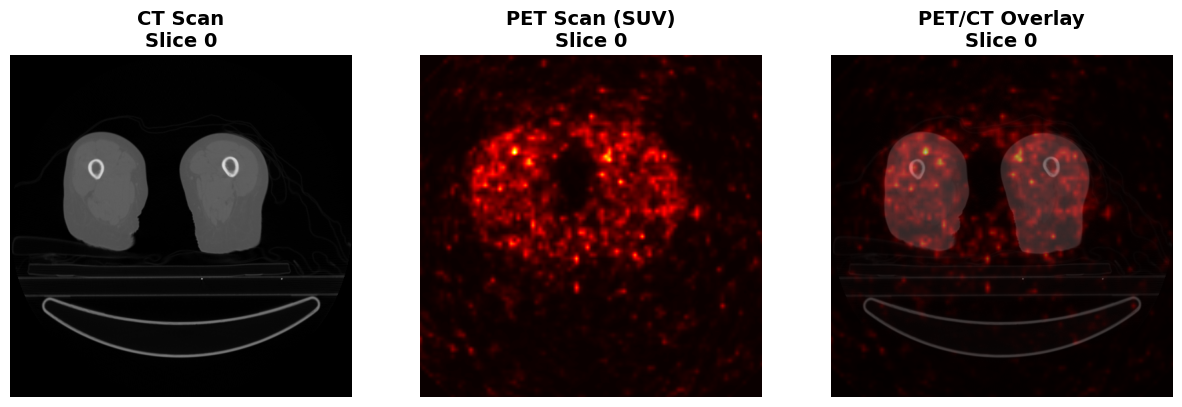

In [10]:
slice_num = 0
print(f"Displaying overlay for slice {slice_num}")

plt.figure(figsize=(8, 8))
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
patientID = next(iter(all_patients_data)) # Corrected line to get the first patient ID

# CT only
axes[0].imshow(all_patients_data[patientID]['ct_array'][slice_num,:,:], cmap='gray')
axes[0].set_title(f'CT Scan\nSlice {slice_num}', fontsize=14, fontweight='bold')
axes[0].axis('off')

# PET only
axes[1].imshow(all_patients_data[patientID]['pet_array'][slice_num,:,:], cmap='hot')
axes[1].set_title(f'PET Scan (SUV)\nSlice {slice_num}', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Overlay
axes[2].imshow(all_patients_data[patientID]['ct_array'][slice_num,:,:], cmap='gray')
axes[2].imshow(all_patients_data[patientID]['pet_array'][slice_num,:,:], cmap='hot', alpha=0.5)
axes[2].set_title(f'PET/CT Overlay\nSlice {slice_num}', fontsize=14, fontweight='bold')
axes[2].axis('off')

In [11]:
patientID

'ACRIN-NSCLC-FDG-PET-251'

Displaying overlay for slice 100


(np.float64(-0.5), np.float64(511.5), np.float64(-0.5), np.float64(286.5))

<Figure size 800x800 with 0 Axes>

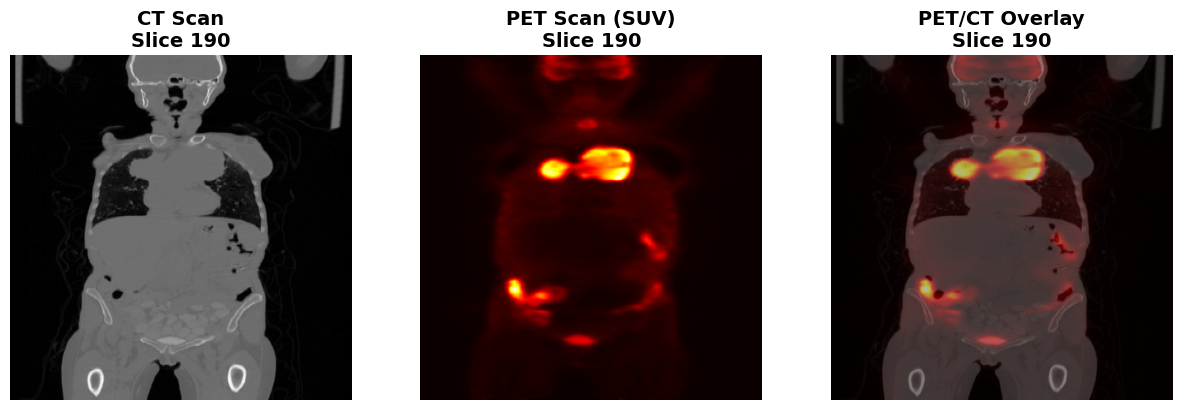

In [12]:
# axial view
slice_num = 190
print(f"Displaying overlay for slice {100}")

plt.figure(figsize=(8, 8))
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CT only
axes[0].imshow(all_patients_data[patientID]['ct_array'][:,slice_num,:], cmap='gray',origin='lower',aspect=1.8)
axes[0].set_title(f'CT Scan\nSlice {slice_num}', fontsize=14, fontweight='bold')
axes[0].axis('off')

# PET only
axes[1].imshow(all_patients_data[patientID]['pet_array'][:,slice_num,:], cmap='hot',origin='lower',aspect=1.8)
axes[1].set_title(f'PET Scan (SUV)\nSlice {slice_num}', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Overlay
axes[2].imshow(all_patients_data[patientID]['ct_array'][:,slice_num,:], cmap='gray',origin='lower',aspect=1.8)
axes[2].imshow(all_patients_data[patientID]['pet_array'][:,slice_num,:], cmap='hot', alpha=0.5,origin='lower',aspect=1.8)
axes[2].set_title(f'PET/CT Overlay\nSlice {slice_num}', fontsize=14, fontweight='bold')
axes[2].axis('off')

# Step 3: Lung mask generation

Segment the lungs from the CT volume using thresholding and morphological operations based on HU values.

In [13]:
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import binary_fill_holes, binary_erosion, binary_dilation
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from typing import Tuple, Optional

# ============================================================================
# STEP 1: BODY SEGMENTATION (Critical for separating lungs from outside air)
# ============================================================================

def segment_body_from_air(ct_array: np.ndarray,
                          threshold: int = -300,
                          min_body_size: int = 10000) -> np.ndarray:
    print("Step 1: Segmenting body from external air...")

    # Create initial body mask (everything above threshold)
    body_mask = ct_array > threshold

    # Fill holes in each slice (important for body cavity)
    for i in range(body_mask.shape[0]):
        body_mask[i] = binary_fill_holes(body_mask[i])

    # Remove small objects (noise)
    labeled_mask, num_features = label(body_mask)

    # Find the largest connected component (the body)
    if num_features > 0:
        component_sizes = np.bincount(labeled_mask.ravel())
        component_sizes[0] = 0  # Ignore background
        largest_component = component_sizes.argmax()
        body_mask = (labeled_mask == largest_component)

    # Morphological closing to smooth body contour
    struct = generate_binary_structure(3, 2)
    body_mask = binary_dilation(body_mask, structure=struct, iterations=3)
    body_mask = binary_erosion(body_mask, structure=struct, iterations=3)

    print(f"  Body mask created: {body_mask.sum()} voxels")
    return body_mask.astype(np.uint8)


# ============================================================================
# STEP 2: LUNG SEGMENTATION (Traditional Method - No CNN Required!)
# ============================================================================

def segment_lungs_traditional(ct_array: np.ndarray,
                              body_mask: np.ndarray,
                              lung_lower: int = -1000,
                              lung_upper: int = -300) -> np.ndarray:

    print("Step 2: Segmenting lungs using traditional method...")

    # Apply HU thresholding ONLY within body mask
    lung_candidates = np.logical_and(
        ct_array >= lung_lower,
        ct_array <= lung_upper
    )

    # Restrict to body region (this eliminates external air!)
    lung_candidates = np.logical_and(lung_candidates, body_mask)

    # CREATE ANATOMICAL POSITION MASK to exclude brain and bladder
    # Lungs are typically in middle 40-70% of body (superior-inferior axis)
    num_slices = ct_array.shape[0]

    # Exclude top 25% (brain/head) and bottom 15% (bladder/pelvis)
    lung_region_start = int(num_slices * 0.25)
    lung_region_end = int(num_slices * 0.85)

    # Create slice-based mask
    anatomical_mask = np.zeros_like(lung_candidates, dtype=bool)
    anatomical_mask[lung_region_start:lung_region_end, :, :] = True

    # Apply anatomical constraint
    lung_candidates = np.logical_and(lung_candidates, anatomical_mask)

    print(f"  Using slices {lung_region_start} to {lung_region_end} (excluding brain/bladder)")

    # Label connected components
    labeled_lungs, num_features = label(lung_candidates)

    # Find the two largest components (left and right lungs)
    component_sizes = np.bincount(labeled_lungs.ravel())
    component_sizes[0] = 0  # Ignore background

    # Get indices of two largest components
    if num_features >= 2:
        largest_indices = np.argsort(component_sizes)[-2:]
        lung_mask = np.isin(labeled_lungs, largest_indices)
    elif num_features == 1:
        largest_idx = component_sizes.argmax()
        lung_mask = (labeled_lungs == largest_idx)
    else:
        print("  Warning: No lung regions found!")
        lung_mask = np.zeros_like(ct_array, dtype=bool)

    # Morphological operations to clean up
    struct = generate_binary_structure(3, 1)

    # Remove small holes
    for i in range(lung_mask.shape[0]):
        lung_mask[i] = binary_fill_holes(lung_mask[i])

    # Smooth boundaries
    lung_mask = binary_erosion(lung_mask, structure=struct, iterations=1)
    lung_mask = binary_dilation(lung_mask, structure=struct, iterations=2)
    lung_mask = binary_erosion(lung_mask, structure=struct, iterations=1)

    print(f"  Lung mask created: {lung_mask.sum()} voxels")
    return lung_mask.astype(np.uint8)
def segment_lungs_traditional(ct_array: np.ndarray,
                              body_mask: np.ndarray,
                              lung_lower: int = -1000,
                              lung_upper: int = -300) -> np.ndarray:
    """
    Segment lungs using traditional image processing.
    Excludes brain (top slices) and bladder (bottom slices).
    """
    print("Step 2: Segmenting lungs using traditional method...")

    # Apply HU thresholding ONLY within body mask
    lung_candidates = np.logical_and(
        ct_array >= lung_lower,
        ct_array <= lung_upper
    )

    # Restrict to body region (this eliminates external air!)
    lung_candidates = np.logical_and(lung_candidates, body_mask)

    # CREATE ANATOMICAL POSITION MASK to exclude brain and bladder
    # Lungs are typically in middle 40-70% of body (superior-inferior axis)
    num_slices = ct_array.shape[0]

    # Exclude top 25% (brain/head) and bottom 25% (bladder/pelvis)
    lung_region_start = int(num_slices * 0.25)
    lung_region_end = int(num_slices * 0.75)

    # Create slice-based mask
    anatomical_mask = np.zeros_like(lung_candidates, dtype=bool)
    anatomical_mask[lung_region_start:lung_region_end, :, :] = True

    # Apply anatomical constraint
    lung_candidates = np.logical_and(lung_candidates, anatomical_mask)

    print(f"  Using slices {lung_region_start} to {lung_region_end} (excluding brain/bladder)")

    # Label connected components
    labeled_lungs, num_features = label(lung_candidates)

    # Find the two largest components (left and right lungs)
    component_sizes = np.bincount(labeled_lungs.ravel())
    component_sizes[0] = 0  # Ignore background

    # Get indices of two largest components
    if num_features >= 2:
        largest_indices = np.argsort(component_sizes)[-2:]
        lung_mask = np.isin(labeled_lungs, largest_indices)
    elif num_features == 1:
        largest_idx = component_sizes.argmax()
        lung_mask = (labeled_lungs == largest_idx)
    else:
        print("  Warning: No lung regions found!")
        lung_mask = np.zeros_like(ct_array, dtype=bool)

    # Morphological operations to clean up
    struct = generate_binary_structure(3, 1)

    # Remove small holes
    for i in range(lung_mask.shape[0]):
        lung_mask[i] = binary_fill_holes(lung_mask[i])

    # Smooth boundaries
    lung_mask = binary_erosion(lung_mask, structure=struct, iterations=1)
    lung_mask = binary_dilation(lung_mask, structure=struct, iterations=2)
    lung_mask = binary_erosion(lung_mask, structure=struct, iterations=1)

    print(f"  Lung mask created: {lung_mask.sum()} voxels")
    return lung_mask.astype(np.uint8)


# ============================================================================
# STEP 3: REFINE LUNG MASK (Remove trachea and major airways)
# ============================================================================

def refine_lung_mask(lung_mask: np.ndarray,
                     ct_array: np.ndarray,
                     remove_airways: bool = True) -> np.ndarray:

    print("Step 3: Refining lung mask...")

    refined_mask = lung_mask.copy()

    if remove_airways:
        # Airways typically have HU closer to air (-1000 to -950)
        # But are connected to trachea at top of lungs

        # Find very dark regions (potential airways)
        very_dark = (ct_array < -950) & (lung_mask > 0)

        # Label them
        labeled_dark, num_dark = label(very_dark)

        # Remove components connected to top slices (trachea)
        if num_dark > 0:
            # Check which components appear in top 20% of slices
            top_slice_idx = int(ct_array.shape[0] * 0.2)
            top_components = np.unique(labeled_dark[:top_slice_idx])
            top_components = top_components[top_components > 0]

            # Remove these components from lung mask
            for comp in top_components:
                refined_mask[labeled_dark == comp] = 0

    print(f"  Refined lung mask: {refined_mask.sum()} voxels")
    return refined_mask


# ============================================================================
# STEP 4: SEPARATE LEFT AND RIGHT LUNGS
# ============================================================================

def separate_left_right_lungs(lung_mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Separate lung mask into left and right lungs.

    Returns:
    --------
    left_lung, right_lung : tuple of np.ndarray
        Separate masks for left and right lungs
    """
    print("Step 4: Separating left and right lungs...")

    labeled_lungs, num_features = label(lung_mask)

    if num_features < 2:
        print("  Warning: Could not separate lungs, returning combined mask")
        return lung_mask, np.zeros_like(lung_mask)

    # Get component sizes
    component_sizes = np.bincount(labeled_lungs.ravel())
    component_sizes[0] = 0

    # Get two largest components
    largest_indices = np.argsort(component_sizes)[-2:]

    # Determine which is left/right based on position
    masks = [(labeled_lungs == idx) for idx in largest_indices]
    centers = [ndimage.center_of_mass(mask) for mask in masks]

    # In medical imaging, patient's right is typically on left side of array
    # (radiological convention)
    if centers[0][2] < centers[1][2]:  # Compare x-coordinate
        right_lung, left_lung = masks
    else:
        left_lung, right_lung = masks

    print(f"  Left lung: {left_lung.sum()} voxels")
    print(f"  Right lung: {right_lung.sum()} voxels")

    return left_lung.astype(np.uint8), right_lung.astype(np.uint8)

## Run the lung_segmentation function

In [14]:
def perform_lung_segmentation(ct_array: np.ndarray, patient_id: str) -> dict:
    """Complete lung segmentation pipeline."""
    print(f"\n{'='*60}")
    print(f"Lung Segmentation for {patient_id}")
    print(f"{'='*60}")

    body_mask = segment_body_from_air(ct_array)
    lung_mask = segment_lungs_traditional(ct_array, body_mask)
    lung_mask_refined = refine_lung_mask(lung_mask, ct_array)
    left_lung, right_lung = separate_left_right_lungs(lung_mask_refined)

    print(f"✓ Segmentation complete for {patient_id}")

    return {
        'body_mask': body_mask,
        'lung_mask': lung_mask,
        'lung_mask_refined': lung_mask_refined,
        'left_lung': left_lung,
        'right_lung': right_lung
    }


# ============================================================================
# PROCESS ALL PATIENTS
# ============================================================================

print("\n" + "="*60)
print("PERFORMING LUNG SEGMENTATION FOR ALL PATIENTS")
print("="*60)

for patient_id, patient_data in all_patients_data.items():
    try:
        ct_array = patient_data['ct_array']
        segmentation_results = perform_lung_segmentation(ct_array, patient_id)
        all_patients_data[patient_id]['segmentation'] = segmentation_results

    except Exception as e:
        print(f"❌ Error segmenting {patient_id}: {e}")

print("\n" + "="*60)
print("LUNG SEGMENTATION COMPLETE")
print("="*60)


PERFORMING LUNG SEGMENTATION FOR ALL PATIENTS

Lung Segmentation for ACRIN-NSCLC-FDG-PET-251
Step 1: Segmenting body from external air...
  Body mask created: 12050820 voxels
Step 2: Segmenting lungs using traditional method...
  Using slices 71 to 215 (excluding brain/bladder)
  Lung mask created: 1319163 voxels
Step 3: Refining lung mask...
  Refined lung mask: 1319163 voxels
Step 4: Separating left and right lungs...
  Left lung: 16 voxels
  Right lung: 1319114 voxels
✓ Segmentation complete for ACRIN-NSCLC-FDG-PET-251

Lung Segmentation for ACRIN-NSCLC-FDG-PET-250
Step 1: Segmenting body from external air...
  Body mask created: 15484414 voxels
Step 2: Segmenting lungs using traditional method...
  Using slices 65 to 197 (excluding brain/bladder)
  Lung mask created: 848483 voxels
Step 3: Refining lung mask...
  Refined lung mask: 848483 voxels
Step 4: Separating left and right lungs...
  Left lung: 32173 voxels
  Right lung: 816016 voxels
✓ Segmentation complete for ACRIN-NSCLC-F

## Check example lung mask in CT scans

In [15]:
from ipywidgets import interactive, fixed
import matplotlib.pyplot as plt
import numpy as np

def plot_lung_segmentation(slice_index, volume_hu, lung_mask):
    """
    Function to display a single slice of the CT volume with the lung mask overlaid.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(volume_hu[slice_index, :, :], cmap='gray')
    # Overlay the lung mask with a color (e.g., green) and transparency
    plt.imshow(lung_mask[slice_index, :, :], cmap='Reds', alpha=0.5)
    plt.title(f"CT Slice {slice_index}/{volume_hu.shape[0]-1} with Lung Mask")
    plt.axis('off')
    plt.show()
patientID = next(iter(all_patients_data))
interactive_plot_lung_mask = interactive(
    plot_lung_segmentation,
    slice_index=(0, all_patients_data[patientID]['ct_array'].shape[0]-1),
    volume_hu=fixed(all_patients_data[patientID]['ct_array']),
    lung_mask=fixed(all_patients_data[patientID]['segmentation']['lung_mask_refined'])
)

print("Interactive plot showing CT slices with segmented lung mask:")

interactive_plot_lung_mask

Interactive plot showing CT slices with segmented lung mask:


interactive(children=(IntSlider(value=143, description='slice_index', max=286), Output()), _dom_classes=('widg…

## Check example lung mask overlapped with PET scans

In [16]:
interactive_plot_lung_mask = interactive(
    plot_lung_segmentation,
    slice_index=(0, all_patients_data[patientID]['ct_array'].shape[0]-1),
    volume_hu=fixed(all_patients_data[patientID]['pet_array']),
    lung_mask=fixed(all_patients_data[patientID]['segmentation']['lung_mask_refined'])
)

print("Interactive plot showing CT slices with segmented lung mask:")

interactive_plot_lung_mask

Interactive plot showing CT slices with segmented lung mask:


interactive(children=(IntSlider(value=143, description='slice_index', max=286), Output()), _dom_classes=('widg…

## Caluculate Ground_truth SUV metrics

In [17]:
import numpy as np
from scipy.ndimage import maximum_filter

def calculate_suv_metrics(pet_suv: np.ndarray, lung_mask: np.ndarray) -> dict:
    # Get SUV values within lung mask
    lung_suv_values = pet_suv[lung_mask > 0]

    if len(lung_suv_values) == 0:
        return {'SUV_max': 0.0, 'SUV_peak': 0.0}

    # Calculate SUV_max
    suv_max = np.max(lung_suv_values)

    # Calculate SUV_peak (mean of 1cm³ sphere around hottest point)
    # Find location of max SUV
    max_location = np.unravel_index(np.argmax(pet_suv * lung_mask), pet_suv.shape)

    # Create 1cm sphere (assuming ~3mm spacing, radius ~3-4 voxels)
    sphere_radius = 3  # voxels
    z, y, x = max_location

    # Extract region around max
    z_min = max(0, z - sphere_radius)
    z_max = min(pet_suv.shape[0], z + sphere_radius + 1)
    y_min = max(0, y - sphere_radius)
    y_max = min(pet_suv.shape[1], y + sphere_radius + 1)
    x_min = max(0, x - sphere_radius)
    x_max = min(pet_suv.shape[2], x + sphere_radius + 1)

    region = pet_suv[z_min:z_max, y_min:y_max, x_min:x_max]
    mask_region = lung_mask[z_min:z_max, y_min:y_max, x_min:x_max]

    # Calculate SUV_peak as mean within this region
    region_values = region[mask_region > 0]
    suv_peak = np.mean(region_values) if len(region_values) > 0 else suv_max

    return {
        'SUV_max': float(suv_max),
        'SUV_peak': float(suv_peak),
        'max_location': max_location
    }


print("\n" + "="*60)
print("CALCULATING SUV METRICS FOR ALL PATIENTS")
print("="*60)

# Iterate through all patients
for patient_id, patient_data in all_patients_data.items():
    print(f"\nProcessing Patient ID: {patient_id}")

    if 'segmentation' not in patient_data:
        print(f"  ⚠ Skipping {patient_id} - no segmentation available")
        continue

    try:
        # Get PET SUV and lung mask
        pet_suv = patient_data['pet_array']
        lung_mask = patient_data['segmentation']['lung_mask_refined']

        # Check shape compatibility
        if pet_suv.shape != lung_mask.shape:
            print(f"  ❌ Shape mismatch! PET: {pet_suv.shape}, Lung Mask: {lung_mask.shape}")
            continue

        # Apply lung mask
        lung_masked_pet = pet_suv * lung_mask

        # Calculate SUV metrics
        suv_metrics = calculate_suv_metrics(pet_suv, lung_mask)

        # Store results
        all_patients_data[patient_id]['suv_metrics'] = suv_metrics
        all_patients_data[patient_id]['lung_masked_pet'] = lung_masked_pet

        # Print results
        print(f"  ✓ SUV_max: {suv_metrics['SUV_max']:.2f}")
        print(f"  ✓ SUV_peak: {suv_metrics['SUV_peak']:.2f}")
        print(f"  ✓ Max location (z,y,x): {suv_metrics['max_location']}")

        # Get lung SUV statistics
        lung_suv_values = pet_suv[lung_mask > 0]
        print(f"  Mean SUV in lungs: {np.mean(lung_suv_values):.2f}")
        print(f"  Median SUV in lungs: {np.median(lung_suv_values):.2f}")
        print(f"  Lung volume: {lung_mask.sum()} voxels")

    except Exception as e:
        print(f"  ❌ Error processing {patient_id}: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*60)
print("SUV METRICS CALCULATION COMPLETE")
print("="*60)

# Summary of all patients
print("\n" + "="*60)
print("SUMMARY OF SUV METRICS")
print("="*60)
print(f"{'Patient ID':<30} {'SUV_max':<12} {'SUV_peak':<12}")
print("-" * 60)

for patient_id, patient_data in all_patients_data.items():
    if 'suv_metrics' in patient_data:
        metrics = patient_data['suv_metrics']
        print(f"{patient_id:<30} {metrics['SUV_max']:<12.2f} {metrics['SUV_peak']:<12.2f}")


CALCULATING SUV METRICS FOR ALL PATIENTS

Processing Patient ID: ACRIN-NSCLC-FDG-PET-251
  ✓ SUV_max: 0.74
  ✓ SUV_peak: 0.26
  ✓ Max location (z,y,x): (np.int64(183), np.int64(164), np.int64(201))
  Mean SUV in lungs: 0.08
  Median SUV in lungs: 0.07
  Lung volume: 1319163 voxels

Processing Patient ID: ACRIN-NSCLC-FDG-PET-250
  ✓ SUV_max: 5.01
  ✓ SUV_peak: 3.56
  ✓ Max location (z,y,x): (np.int64(176), np.int64(282), np.int64(195))
  Mean SUV in lungs: 0.98
  Median SUV in lungs: 0.88
  Lung volume: 848483 voxels

Processing Patient ID: ACRIN-NSCLC-FDG-PET-244_1
  ✓ SUV_max: 14.12
  ✓ SUV_peak: 8.81
  ✓ Max location (z,y,x): (np.int64(173), np.int64(244), np.int64(319))
  Mean SUV in lungs: 1.50
  Median SUV in lungs: 1.31
  Lung volume: 1509349 voxels

Processing Patient ID: ACRIN-NSCLC-FDG-PET-244_2
  ✓ SUV_max: 10.39
  ✓ SUV_peak: 8.54
  ✓ Max location (z,y,x): (np.int64(220), np.int64(326), np.int64(219))
  Mean SUV in lungs: 1.01
  Median SUV in lungs: 0.79
  Lung volume: 1468

Traceback (most recent call last):
  File "/tmp/ipython-input-1101274079.py", line 79, in <cell line: 0>
    print(f"  ✓ Max location (z,y,x): {suv_metrics['max_location']}")
                                       ~~~~~~~~~~~^^^^^^^^^^^^^^^^
KeyError: 'max_location'
Traceback (most recent call last):
  File "/tmp/ipython-input-1101274079.py", line 79, in <cell line: 0>
    print(f"  ✓ Max location (z,y,x): {suv_metrics['max_location']}")
                                       ~~~~~~~~~~~^^^^^^^^^^^^^^^^
KeyError: 'max_location'
Traceback (most recent call last):
  File "/tmp/ipython-input-1101274079.py", line 79, in <cell line: 0>
    print(f"  ✓ Max location (z,y,x): {suv_metrics['max_location']}")
                                       ~~~~~~~~~~~^^^^^^^^^^^^^^^^
KeyError: 'max_location'


  ✓ SUV_max: 4.50
  ✓ SUV_peak: 2.94
  ✓ Max location (z,y,x): (np.int64(213), np.int64(257), np.int64(194))
  Mean SUV in lungs: 0.53
  Median SUV in lungs: 0.45
  Lung volume: 613973 voxels

Processing Patient ID: ACRIN-NSCLC-FDG-PET-248_2
  ✓ SUV_max: 0.00
  ✓ SUV_peak: 0.00
  ❌ Error processing ACRIN-NSCLC-FDG-PET-248_2: 'max_location'

Processing Patient ID: ACRIN-NSCLC-FDG-PET-243_1


Traceback (most recent call last):
  File "/tmp/ipython-input-1101274079.py", line 79, in <cell line: 0>
    print(f"  ✓ Max location (z,y,x): {suv_metrics['max_location']}")
                                       ~~~~~~~~~~~^^^^^^^^^^^^^^^^
KeyError: 'max_location'


  ✓ SUV_max: 0.00
  ✓ SUV_peak: 0.00
  ✓ Max location (z,y,x): (np.int64(189), np.int64(286), np.int64(350))
  Mean SUV in lungs: 0.00
  Median SUV in lungs: 0.00
  Lung volume: 3075873 voxels

Processing Patient ID: ACRIN-NSCLC-FDG-PET-243_2
  ✓ SUV_max: 14.69
  ✓ SUV_peak: 9.94
  ✓ Max location (z,y,x): (np.int64(223), np.int64(301), np.int64(201))
  Mean SUV in lungs: 0.87
  Median SUV in lungs: 0.67
  Lung volume: 1745518 voxels

Processing Patient ID: ACRIN-NSCLC-FDG-PET-243_3
  ✓ SUV_max: 11.38
  ✓ SUV_peak: 6.74
  ✓ Max location (z,y,x): (np.int64(195), np.int64(269), np.int64(349))
  Mean SUV in lungs: 0.62
  Median SUV in lungs: 0.50
  Lung volume: 1422140 voxels

Processing Patient ID: ACRIN-NSCLC-FDG-PET-247
  ✓ SUV_max: 0.11
  ✓ SUV_peak: 0.06
  ✓ Max location (z,y,x): (np.int64(184), np.int64(282), np.int64(378))
  Mean SUV in lungs: 0.01
  Median SUV in lungs: 0.01
  Lung volume: 944064 voxels

SUV METRICS CALCULATION COMPLETE

SUMMARY OF SUV METRICS
Patient ID           

# Step 4: Train a 2D-CNN model to automatically detect lung section

import numpy as np
from scipy import ndimage
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------------------------------------------
# 1. PREPARE 2D TRAINING DATA (SLICE-BASED)
# -------------------------------------------------------------
def prepare_2d_training_data(converted_volumes_data, lung_masks_refined_data, target_size=(128, 128)):
    """
    Prepare 2D slice-based training data.
    Each slice becomes an independent training sample.
    
    Args:
        converted_volumes_data: Dictionary with CT volumes
        lung_masks_refined_data: Dictionary with lung masks
        target_size: Target size for each slice (height, width)
    
    Returns:
        X_train: Array of shape (n_slices, height, width, 1)
        y_train: Array of shape (n_slices, height, width, 1)
    """
    
    X_slices = []
    y_slices = []
    
    print("\n" + "="*60)
    print("PREPARING 2D SLICE-BASED TRAINING DATA")
    print("="*60)
    print(f"Target slice size: {target_size}")
    print("="*60)
    
    for patient_id, data in converted_volumes_data.items():
        
        volume_ct_hu = data.get('volume_ct_hu')
        lung_mask_refined = lung_masks_refined_data.get(patient_id)
        
        # Skip if missing data
        if volume_ct_hu is None or lung_mask_refined is None:
            continue
        
        # Skip if shapes don't match
        if volume_ct_hu.shape != lung_mask_refined.shape:
            continue
        
        try:
            # Normalize CT volume to [0, 1]
            min_hu = np.min(volume_ct_hu)
            max_hu = np.max(volume_ct_hu)
            
            if (max_hu - min_hu) == 0:
                normalized_volume = np.zeros_like(volume_ct_hu, dtype=np.float32)
            else:
                normalized_volume = (volume_ct_hu - min_hu) / (max_hu - min_hu)
            
            # Process each slice in the volume
            num_slices = volume_ct_hu.shape[0]
            
            for slice_idx in range(num_slices):
                # Extract slice
                ct_slice = normalized_volume[slice_idx, :, :]
                mask_slice = lung_mask_refined[slice_idx, :, :]
                
                # Skip empty slices (no lung tissue)
                if np.sum(mask_slice) == 0:
                    continue
                
                # Resize slice to target size
                ct_resized = ndimage.zoom(
                    ct_slice,
                    [target_size[0] / ct_slice.shape[0],
                     target_size[1] / ct_slice.shape[1]],
                    order=1,  # Linear interpolation
                    mode='nearest'
                )
                
                mask_resized = ndimage.zoom(
                    mask_slice,
                    [target_size[0] / mask_slice.shape[0],
                     target_size[1] / mask_slice.shape[1]],
                    order=0  # Nearest neighbor
                )
                mask_resized = (mask_resized > 0.5).astype(np.uint8)
                
                # Append slices
                X_slices.append(ct_resized)
                y_slices.append(mask_resized)
        
        except Exception as e:
            continue
    
    # Convert to numpy arrays
    if len(X_slices) == 0:
        raise ValueError("No valid slices found!")
    
    X_train = np.array(X_slices, dtype=np.float32)
    y_train = np.array(y_slices, dtype=np.uint8)
    
    # Add channel dimension: (n, h, w) -> (n, h, w, 1)
    X_train = X_train[..., np.newaxis]
    y_train = y_train[..., np.newaxis]
    
    print("\n" + "="*60)
    print("DATA PREPARATION COMPLETE")
    print("="*60)
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"Total slices: {X_train.shape[0]}")
    print("="*60)
    
    return X_train, y_train


# -------------------------------------------------------------
# 2. BUILD 2D U-NET MODEL
# -------------------------------------------------------------
def build_2d_unet(input_shape=(128, 128, 1)):
    """
    Build a 2D U-Net for slice-based lung segmentation.
    """
    inputs = keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    u7 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u8 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u9 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# -------------------------------------------------------------
# 3. LOSS FUNCTIONS AND METRICS
# -------------------------------------------------------------
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


# -------------------------------------------------------------
# 4. DATA AUGMENTATION (2D)
# -------------------------------------------------------------
def augment_2d_slice(image, mask):
    """Augment a 2D image-mask pair."""
    
    # Random rotation (90, 180, 270 degrees)
    if np.random.rand() > 0.5:
        k = np.random.randint(1, 4)
        image = np.rot90(image, k=k)
        mask = np.rot90(mask, k=k)
    
    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    
    # Random vertical flip
    if np.random.rand() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    
    # Random intensity adjustment
    if np.random.rand() > 0.5:
        image = np.clip(image * np.random.uniform(0.9, 1.1), 0, 1)
    
    return image.copy(), mask.copy()


# -------------------------------------------------------------
# 5. TRAINING FUNCTION
# -------------------------------------------------------------
def train_2d_model(X_train, y_train, X_val=None, y_val=None, epochs=50, batch_size=16):
    """
    Train 2D U-Net model.
    """
    print("\n" + "="*60)
    print("TRAINING 2D U-NET MODEL")
    print("="*60)

    model = build_2d_unet(input_shape=X_train.shape[1:])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=combined_loss,
        metrics=[dice_coefficient, 'binary_accuracy']
    )

    print(f"\nModel Summary:")
    model.summary()

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            'lung_segmentation_2d_model.h5',
            save_best_only=True,
            monitor='val_dice_coefficient' if X_val is not None else 'dice_coefficient',
            mode='max',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Data generator with augmentation
    def data_generator(X, y, batch_size=16, augment=True):
        while True:
            indices = np.random.permutation(len(X))
            for i in range(0, len(X), batch_size):
                batch_indices = indices[i:i+batch_size]
                batch_X, batch_y = [], []
                
                for idx in batch_indices:
                    img = X[idx, :, :, 0]
                    msk = y[idx, :, :, 0]
                    
                    if augment:
                        img, msk = augment_2d_slice(img, msk)
                    
                    batch_X.append(img[..., np.newaxis])
                    batch_y.append(msk[..., np.newaxis].astype(np.float32))
                
                yield np.array(batch_X), np.array(batch_y)

    train_gen = data_generator(X_train, y_train, batch_size=batch_size, augment=True)
    val_data = (X_val, y_val.astype(np.float32)) if X_val is not None else None

    print(f"\nStarting training...")
    print(f"Training slices: {X_train.shape[0]}")
    if X_val is not None:
        print(f"Validation slices: {X_val.shape[0]}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print("="*60)

    history = model.fit(
        train_gen,
        steps_per_epoch=len(X_train) // batch_size,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    print("\n" + "="*60)
    print("✓ Training complete!")
    print(f"✓ Model saved to: lung_segmentation_2d_model.h5")
    print("="*60)
    
    return model, history


# -------------------------------------------------------------
# 6. MAIN EXECUTION
# -------------------------------------------------------------

# Prepare 2D training data
X_train, y_train = prepare_2d_training_data(
    converted_volumes_data=converted_volumes_data,
    lung_masks_refined_data=lung_masks_refined_data,
    target_size=(128, 128)
)

# Split into train/validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"\n✓ Split: {X_train_split.shape[0]} training, {X_val_split.shape[0]} validation slices")

# Train the model
model, history = train_2d_model(
    X_train_split, y_train_split,
    X_val=X_val_split, y_val=y_val_split,
    epochs=50,
    batch_size=16
)

print("\n" + "="*60)
print("2D U-NET TRAINING COMPLETE")
print("="*60)

# Step 5: Generate lung masks through the 2D-CNN model

## Load pretrained model

In [18]:
from tensorflow import keras
import tensorflow as tf

model_path = '/content/gdrive/MyDrive/ACRIN_Pretreatment_dataset/lung_segmentation_2d_model.h5'

# Load without compilation
model = keras.models.load_model(model_path, compile=False)

# Manually compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✓ Model loaded successfully!")
model.summary()

✓ Model loaded successfully!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_21[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_22[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_23[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ dropout_24[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]  

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

## Predict lung masks with CT arrays

In [19]:
# PREDICT LUNG MASK FROM CT VOLUME (SLICE-BY-SLICE)
# -------------------------------------------------------------
def predict_lung_mask_2d(model, volume_ct_hu, target_size=(128, 128), threshold=0.5):
    """
    Predict lung mask from CT volume using 2D U-Net.
    Processes each slice independently and reconstructs the 3D mask.

    Args:
        model: Trained 2D U-Net model
        volume_ct_hu: 3D CT volume in Hounsfield Units (depth, height, width)
        target_size: Model input size (height, width)
        threshold: Threshold for binary segmentation

    Returns:
        predicted_mask: Binary lung mask in original shape
        prediction_prob: Prediction probabilities in original shape
    """

    original_shape = volume_ct_hu.shape
    num_slices = original_shape[0]

    print("\n" + "="*60)
    print("PREDICTING LUNG MASK (2D SLICE-BY-SLICE)")
    print("="*60)
    print(f"Input CT volume shape: {original_shape}")
    print(f"Number of slices: {num_slices}")
    print(f"Target slice size: {target_size}")

    # Normalize entire volume
    min_hu = np.min(volume_ct_hu)
    max_hu = np.max(volume_ct_hu)

    if (max_hu - min_hu) == 0:
        normalized_volume = np.zeros_like(volume_ct_hu, dtype=np.float32)
    else:
        normalized_volume = (volume_ct_hu - min_hu) / (max_hu - min_hu)

    print(f"✓ Normalized volume (HU: {min_hu:.1f} to {max_hu:.1f})")

    # Initialize arrays for predictions
    predicted_mask = np.zeros(original_shape, dtype=np.uint8)
    prediction_prob = np.zeros(original_shape, dtype=np.float32)

    # Process each slice
    print(f"\nProcessing {num_slices} slices...")

    for slice_idx in range(num_slices):
        # Extract and resize slice
        ct_slice = normalized_volume[slice_idx, :, :]

        # Resize to model input size
        ct_resized = ndimage.zoom(
            ct_slice,
            [target_size[0] / ct_slice.shape[0],
             target_size[1] / ct_slice.shape[1]],
            order=1,
            mode='nearest'
        )

        # Add batch and channel dimensions: (H, W) -> (1, H, W, 1)
        ct_input = ct_resized[np.newaxis, ..., np.newaxis]

        # Predict
        pred_slice = model.predict(ct_input, verbose=0)

        # Remove batch and channel dimensions: (1, H, W, 1) -> (H, W)
        pred_slice = pred_slice[0, :, :, 0]

        # Resize back to original slice size
        pred_resized = ndimage.zoom(
            pred_slice,
            [ct_slice.shape[0] / pred_slice.shape[0],
             ct_slice.shape[1] / pred_slice.shape[1]],
            order=1,
            mode='nearest'
        )

        # Store probability and binary mask
        prediction_prob[slice_idx, :, :] = pred_resized
        predicted_mask[slice_idx, :, :] = (pred_resized > threshold).astype(np.uint8)

        # Progress indicator
        if (slice_idx + 1) % 50 == 0 or (slice_idx + 1) == num_slices:
            print(f"  Processed {slice_idx + 1}/{num_slices} slices")

    lung_volume = np.sum(predicted_mask)
    lung_percentage = (lung_volume / predicted_mask.size) * 100

    print("\n" + "="*60)
    print("PREDICTION COMPLETE")
    print("="*60)
    print(f"✓ Predicted mask shape: {predicted_mask.shape}")
    print(f"✓ Lung volume: {lung_volume:,} voxels")
    print(f"✓ Lung percentage: {lung_percentage:.2f}%")
    print(f"✓ Probability range: [{prediction_prob.min():.3f}, {prediction_prob.max():.3f}]")
    print("="*60)

    return predicted_mask, prediction_prob

In [20]:
# Batch prediction for all patients

# Store predictions
predictions_data = {}

# Iterate through all patients
for patient_id, patient_data in all_patients_data.items():
    print(f"\nProcessing Patient: {patient_id}")

    try:
        # Get CT volume and ground truth
        volume_ct_hu = patient_data['ct_array']
        ground_truth_mask = patient_data['segmentation']['lung_mask_refined']

        # Predict
        predicted_mask, prediction_prob = predict_lung_mask_2d(
            model=model,
            volume_ct_hu=volume_ct_hu,
            target_size=(128, 128),
            threshold=0.5
        )

        # Store results
        predictions_data[patient_id] = {
            'predicted_mask': predicted_mask,
            'prediction_prob': prediction_prob,
            'ground_truth_mask': ground_truth_mask
        }

        print(f"  ✓ Prediction complete")
        print(f"  Predicted shape: {predicted_mask.shape}")
        print(f"  Ground truth shape: {ground_truth_mask.shape}")

    except Exception as e:
        print(f"  ❌ Error: {e}")

print("\n" + "="*60)
print(f"Predictions complete for {len(predictions_data)} patients")
print("="*60)

# Quick summary
print("\nSummary:")
for patient_id in predictions_data.keys():
    pred_voxels = predictions_data[patient_id]['predicted_mask'].sum()
    gt_voxels = predictions_data[patient_id]['ground_truth_mask'].sum()
    print(f"  {patient_id}: Predicted={pred_voxels}, Ground Truth={gt_voxels}")


Processing Patient: ACRIN-NSCLC-FDG-PET-251

PREDICTING LUNG MASK (2D SLICE-BY-SLICE)
Input CT volume shape: (287, 512, 512)
Number of slices: 287
Target slice size: (128, 128)
✓ Normalized volume (HU: -1024.0 to 3071.0)

Processing 287 slices...
  Processed 50/287 slices
  Processed 100/287 slices
  Processed 150/287 slices
  Processed 200/287 slices
  Processed 250/287 slices
  Processed 287/287 slices

PREDICTION COMPLETE
✓ Predicted mask shape: (287, 512, 512)
✓ Lung volume: 1,960,738 voxels
✓ Lung percentage: 2.61%
✓ Probability range: [0.000, 1.000]
  ✓ Prediction complete
  Predicted shape: (287, 512, 512)
  Ground truth shape: (287, 512, 512)

Processing Patient: ACRIN-NSCLC-FDG-PET-250

PREDICTING LUNG MASK (2D SLICE-BY-SLICE)
Input CT volume shape: (263, 512, 512)
Number of slices: 263
Target slice size: (128, 128)
✓ Normalized volume (HU: -3024.0 to 3071.0)

Processing 263 slices...
  Processed 50/263 slices
  Processed 100/263 slices
  Processed 150/263 slices
  Processed 

# Step 6: Calculate SUV_max and SUV_peak (Tumor severtity) in PET scans within lung mask

In [21]:
import numpy as np

def calculate_suv_metrics_predicted(pet_suv: np.ndarray, predicted_mask: np.ndarray) -> dict:
    """
    Calculate SUV_max and SUV_peak using predicted lung mask.

    Parameters:
    -----------
    pet_suv : np.ndarray
        PET volume in SUV units
    predicted_mask : np.ndarray
        Predicted lung mask

    Returns:
    --------
    dict with SUV_max and SUV_peak values
    """
    # Get SUV values within predicted lung mask
    lung_suv_values = pet_suv[predicted_mask > 0]

    if len(lung_suv_values) == 0:
        return {'SUV_max': 0.0, 'SUV_peak': 0.0}

    # Calculate SUV_max
    suv_max = np.max(lung_suv_values)

    # Calculate SUV_peak (mean of 1cm³ sphere around hottest point)
    max_location = np.unravel_index(np.argmax(pet_suv * predicted_mask), pet_suv.shape)

    # Create sphere around max (radius ~3 voxels)
    sphere_radius = 3
    z, y, x = max_location

    z_min = max(0, z - sphere_radius)
    z_max = min(pet_suv.shape[0], z + sphere_radius + 1)
    y_min = max(0, y - sphere_radius)
    y_max = min(pet_suv.shape[1], y + sphere_radius + 1)
    x_min = max(0, x - sphere_radius)
    x_max = min(pet_suv.shape[2], x + sphere_radius + 1)

    region = pet_suv[z_min:z_max, y_min:y_max, x_min:x_max]
    mask_region = predicted_mask[z_min:z_max, y_min:y_max, x_min:x_max]

    region_values = region[mask_region > 0]
    suv_peak = np.mean(region_values) if len(region_values) > 0 else suv_max

    return {
        'SUV_max': float(suv_max),
        'SUV_peak': float(suv_peak),
        'max_location': max_location,
        'mean_suv': float(np.mean(lung_suv_values)),
        'median_suv': float(np.median(lung_suv_values))
    }


print("\n" + "="*60)
print("CALCULATING SUV METRICS WITH PREDICTED MASKS")
print("="*60)

# Calculate SUV metrics for all patients using predicted masks
for patient_id in predictions_data.keys():
    print(f"\nProcessing {patient_id}...")

    try:
        # Get PET SUV and predicted mask
        pet_suv = all_patients_data[patient_id]['pet_array']
        predicted_mask = predictions_data[patient_id]['predicted_mask']

        # Calculate SUV metrics
        suv_metrics_pred = calculate_suv_metrics_predicted(pet_suv, predicted_mask)

        # Store results
        predictions_data[patient_id]['suv_metrics_predicted'] = suv_metrics_pred

        # Print results
        print(f"  ✓ SUV_max (predicted):  {suv_metrics_pred['SUV_max']:.2f}")
        print(f"  ✓ SUV_peak (predicted): {suv_metrics_pred['SUV_peak']:.2f}")
        print(f"  Mean SUV (predicted):   {suv_metrics_pred['mean_suv']:.2f}")

        # Compare with ground truth if available
        if 'suv_metrics' in all_patients_data[patient_id]:
            gt_metrics = all_patients_data[patient_id]['suv_metrics']
            print(f"\n  Ground Truth Comparison:")
            print(f"    GT SUV_max:  {gt_metrics['SUV_max']:.2f}")
            print(f"    GT SUV_peak: {gt_metrics['SUV_peak']:.2f}")
            print(f"    Difference (max):  {abs(suv_metrics_pred['SUV_max'] - gt_metrics['SUV_max']):.2f}")
            print(f"    Difference (peak): {abs(suv_metrics_pred['SUV_peak'] - gt_metrics['SUV_peak']):.2f}")

    except Exception as e:
        print(f"  ❌ Error: {e}")

print("\n" + "="*60)
print("SUV METRICS CALCULATION COMPLETE")
print("="*60)


# Summary table
print("\n" + "="*60)
print("COMPARISON: PREDICTED VS GROUND TRUTH")
print("="*60)
print(f"{'Patient ID':<30} {'Pred Max':<12} {'GT Max':<12} {'Pred Peak':<12} {'GT Peak':<12}")
print("-" * 90)

for patient_id in predictions_data.keys():
    if 'suv_metrics_predicted' in predictions_data[patient_id]:
        pred_metrics = predictions_data[patient_id]['suv_metrics_predicted']

        if 'suv_metrics' in all_patients_data[patient_id]:
            gt_metrics = all_patients_data[patient_id]['suv_metrics']
            print(f"{patient_id:<30} {pred_metrics['SUV_max']:<12.2f} {gt_metrics['SUV_max']:<12.2f} "
                  f"{pred_metrics['SUV_peak']:<12.2f} {gt_metrics['SUV_peak']:<12.2f}")
        else:
            print(f"{patient_id:<30} {pred_metrics['SUV_max']:<12.2f} {'N/A':<12} "
                  f"{pred_metrics['SUV_peak']:<12.2f} {'N/A':<12}")


CALCULATING SUV METRICS WITH PREDICTED MASKS

Processing ACRIN-NSCLC-FDG-PET-251...
  ✓ SUV_max (predicted):  0.84
  ✓ SUV_peak (predicted): 0.70
  Mean SUV (predicted):   0.06

  Ground Truth Comparison:
    GT SUV_max:  0.74
    GT SUV_peak: 0.26
    Difference (max):  0.10
    Difference (peak): 0.44

Processing ACRIN-NSCLC-FDG-PET-250...
  ✓ SUV_max (predicted):  8.97
  ✓ SUV_peak (predicted): 2.88
  Mean SUV (predicted):   0.57

  Ground Truth Comparison:
    GT SUV_max:  5.01
    GT SUV_peak: 3.56
    Difference (max):  3.95
    Difference (peak): 0.67

Processing ACRIN-NSCLC-FDG-PET-244_1...
  ✓ SUV_max (predicted):  50.78
  ✓ SUV_peak (predicted): 48.11
  Mean SUV (predicted):   2.60

  Ground Truth Comparison:
    GT SUV_max:  14.12
    GT SUV_peak: 8.81
    Difference (max):  36.66
    Difference (peak): 39.31

Processing ACRIN-NSCLC-FDG-PET-244_2...
  ✓ SUV_max (predicted):  25.97
  ✓ SUV_peak (predicted): 22.32
  Mean SUV (predicted):   2.02

  Ground Truth Comparison:
   

# Step 7: Save the summary SUV metrics

In [22]:
import pandas as pd
from datetime import datetime
import os

# Collect data
summary_data = []
for patient_id in predictions_data.keys():
    if 'suv_metrics_predicted' in predictions_data[patient_id]:
        pred_metrics = predictions_data[patient_id]['suv_metrics_predicted']

        row = {
            'Patient_ID': patient_id,
            'Predicted_SUV_max': pred_metrics['SUV_max'],
            'Predicted_SUV_peak': pred_metrics['SUV_peak'],
        }

        if 'suv_metrics' in all_patients_data[patient_id]:
            gt_metrics = all_patients_data[patient_id]['suv_metrics']
            row['GT_SUV_max'] = gt_metrics['SUV_max']
            row['GT_SUV_peak'] = gt_metrics['SUV_peak']

        summary_data.append(row)

# Save to TSV
df = pd.DataFrame(summary_data)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'suv_metrics_{timestamp}.tsv'
df.to_csv(filename, sep='\t', index=False)
print(f"✓ Saved to: {filename}")

✓ Saved to: suv_metrics_20251126_161711.tsv


# Step 8: Combine all lung cancer SUV metrics

In [23]:
cd ..

/content/gdrive/MyDrive/ACRIN_Pretreatment_dataset


In [24]:
ls

1batch1/   1batch15/  1batch20/  1batch3/  1batch9/
1batch10/  1batch16/  1batch21/  1batch4/  lung_segmentation_2d_model.h5
1batch11/  1batch17/  1batch22/  1batch5/
1batch12/  1batch18/  1batch23/  1batch6/
1batch13/  1batch19/  1batch24/  1batch7/
1batch14/  1batch2/   1batch25/  1batch8/


In [32]:
import pandas as pd
import os
import glob

# Combine all batches
all_dfs = []
first_batch = True
column_names = None

for i in range(1, 25):
    # Find all TSV files in the batch folder
    tsv_files = glob.glob(f'1batch{i}/*.tsv')

    if tsv_files:
        # Use the first TSV file found
        file_path = tsv_files[0]

        if first_batch:
            # Read with header for first batch
            df = pd.read_csv(file_path, sep='\t')
            column_names = df.columns.tolist()  # Save original column names
            first_batch = False
            print(f'✓ Loaded 1batch{i}: {os.path.basename(file_path)} ({len(df)} rows) [WITH HEADER]')
        else:
            # Skip header for subsequent batches
            df = pd.read_csv(file_path, sep='\t', skiprows=1, header=None)
            # Use original column names (before Batch was added)
            df.columns = column_names
            print(f'✓ Loaded 1batch{i}: {os.path.basename(file_path)} ({len(df)} rows) [HEADER SKIPPED]')

        # Add batch column AFTER setting column names
        df['Batch'] = f'1batch{i}'
        all_dfs.append(df)
    else:
        print(f'✗ 1batch{i}: No TSV file found')

# Save combined file
if all_dfs:
    combined = pd.concat(all_dfs, ignore_index=True)
    combined.to_csv('combined_all.tsv', sep='\t', index=False)
    print(f'\n✓ Done! Total rows: {len(combined)} from {len(all_dfs)} batches')
    print(f'✓ Columns: {list(combined.columns)}')
else:
    print('\n✗ No TSV files found!')

✓ Loaded 1batch1: suv_metrics_20251124_225239.tsv (13 rows) [WITH HEADER]
✓ Loaded 1batch2: suv_metrics_20251124_221053.tsv (15 rows) [HEADER SKIPPED]
✓ Loaded 1batch3: suv_metrics_20251124_232038.tsv (20 rows) [HEADER SKIPPED]
✓ Loaded 1batch4: suv_metrics_20251124_235824.tsv (22 rows) [HEADER SKIPPED]
✓ Loaded 1batch5: suv_metrics_20251125_010353.tsv (15 rows) [HEADER SKIPPED]
✓ Loaded 1batch6: suv_metrics_20251125_015101.tsv (19 rows) [HEADER SKIPPED]
✓ Loaded 1batch7: suv_metrics_20251125_022435.tsv (11 rows) [HEADER SKIPPED]
✓ Loaded 1batch8: suv_metrics_20251125_154336.tsv (17 rows) [HEADER SKIPPED]
✓ Loaded 1batch9: suv_metrics_20251125_160316.tsv (21 rows) [HEADER SKIPPED]
✓ Loaded 1batch10: suv_metrics_20251125_163314.tsv (20 rows) [HEADER SKIPPED]
✓ Loaded 1batch11: suv_metrics_20251125_165702.tsv (16 rows) [HEADER SKIPPED]
✓ Loaded 1batch12: suv_metrics_20251125_171526.tsv (15 rows) [HEADER SKIPPED]
✓ Loaded 1batch13: suv_metrics_20251125_174415.tsv (16 rows) [HEADER SKIPPED